In [5]:
# default_exp feature_comparison

# Feature comparison between IDEAS, CP and SCIP features

In this notebook, we will compare feature sets generated using IDEAS, CellProfiler and SCIP. 

In [4]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

import pyarrow.parquet as pq

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [2]:
# export
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr
from ehv import core

## Loading the three feature sets

In [3]:
# cellprofiler features
df_cp = pandas.concat([
    pandas.read_csv(f"/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/cp_output/202111022047_4/{i}/BF_cells_on_grid.csv", skiprows=1)
    for i in range(1,5)
])
df_cp = df_cp.drop(columns=df_cp.filter(regex="\.1$"))

cp_meta_cols = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
cp_meta_cols.extend(df_cp.filter(regex="(FileName|PathName)").columns.values.tolist())
df_cp = df_cp.rename(columns=lambda col: f"meta_{col.lower()}" if col in cp_meta_cols else f"feat_{col.lower()}")
df_cp = df_cp[~df_cp["meta_pathname_1"].isna()]

groups = df_cp["meta_pathname_1"].map(lambda p: re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", Path(p).name).groupdict()).tolist()
df_cp["meta_group"] = list(map(lambda a: int(a["group"]), groups))
df_cp["meta_type"] = list(map(lambda a: a["type"], groups))
df_cp["meta_replicate"] = list(map(lambda a: int(a["replicate"]), groups))

df_cp = df_cp.drop(columns=df_cp.filter(regex="(filemame|pathname)").columns)

df_cp.shape

FileNotFoundError: [Errno 2] No such file or directory: '/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/cp_output/202111022047_4/1/BF_cells_on_grid.csv'

In [ ]:
df_cp = df_cp[~df_cp["feat_areashape_area"].isna()]
df_cp.shape

In [9]:
df_scip = pq.read_table("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111181000/features.parquet").to_pandas()
df_scip["meta_object_number"] = df_scip.index.map(lambda a: a.split("_")[1]).astype(int)
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip.shape

(142451, 1042)

In [10]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(126014, 1042)

In [11]:
# ideas features
tmp = []
for p in Path("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

## Are there NaN values, in what features and rows do they occur?

In [12]:
nan_cp = df_cp.filter(regex="feat").columns[df_cp.filter(regex="feat").isna().any()]
nan_cp

Index(['feat_location_center_x', 'feat_location_center_y'], dtype='object')

In [13]:
nan_scip = df_scip.filter(regex="feat").columns[df_scip.filter(regex="feat").isna().any()]
nan_scip

Index(['feat_inertia_tensor_0', 'feat_inertia_tensor_eigvals_0',
       'feat_moments_hu_0', 'feat_eccentricity_1', 'feat_euler_number_1',
       'feat_inertia_tensor_1', 'feat_inertia_tensor_eigvals_1',
       'feat_moments_hu_1', 'feat_orientation_1', 'feat_solidity_1',
       ...
       'feat_bgcorr_hog_28_6', 'feat_bgcorr_hog_29_6', 'feat_bgcorr_hog_30_6',
       'feat_bgcorr_hog_31_6', 'feat_bgcorr_hog_32_6', 'feat_bgcorr_hog_33_6',
       'feat_bgcorr_hog_34_6', 'feat_bgcorr_hog_35_6',
       'feat_shannon_entropy_6', 'feat_bgcorr_shannon_entropy_6'],
      dtype='object', length=635)

In [14]:
nan_ideas = df_ideas.filter(regex="feat").columns[df_ideas.filter(regex="feat").isna().any()]
nan_ideas

Index([], dtype='object')

In [15]:
df_cp = df_cp.drop(columns=nan_cp)
df_cp.shape

(10222, 253)

In [16]:
df_scip = df_scip.drop(columns=nan_scip)
df_scip.shape

(126014, 407)

## Are there any zero-variance or NaN-variance features?

In [17]:
zero_var_scip = df_scip.filter(regex="feat.*").loc[:, df_scip.filter(regex="feat.*").var(axis=0) == 0].columns
zero_var_scip

Index(['feat_edge_min_0', 'feat_bgcorr_edge_min_0'], dtype='object')

In [18]:
zero_var_cp = df_cp.filter(regex="feat.*").loc[:, df_cp.filter(regex="feat.*").var(axis=0) == 0].columns
zero_var_cp

Index(['feat_areashape_eulernumber', 'feat_location_centermassintensity_z_r1',
       'feat_location_maxintensity_z_r1',
       'feat_location_centermassintensity_z_r3',
       'feat_location_centermassintensity_z_r7',
       'feat_location_maxintensity_z_r3', 'feat_location_maxintensity_z_r7'],
      dtype='object')

In [19]:
zero_var_ideas = df_ideas.filter(regex="feat.*").loc[:, df_ideas.filter(regex="feat.*").var(axis=0) == 0].columns
zero_var_ideas

Index([], dtype='object')

In [20]:
df_scip = df_scip.drop(columns=zero_var_scip)
df_scip.shape

(126014, 405)

In [21]:
df_cp = df_cp.drop(columns=zero_var_cp)
df_cp.shape

(10222, 246)

In [22]:
nan_var_scip = df_scip.filter(regex="feat.*").columns[df_scip.filter(regex="feat.*").var(axis=0).isna()]
nan_var_scip

Index([], dtype='object')

In [23]:
nan_var_cp = df_cp.filter(regex="feat.*").columns[df_cp.filter(regex="feat.*").var(axis=0).isna()]
nan_var_cp

Index([], dtype='object')

In [24]:
nan_var_ideas = df_ideas.filter(regex="feat.*").columns[df_ideas.filter(regex="feat.*").var(axis=0).isna()]
nan_var_ideas

Index([], dtype='object')

In [25]:
df_scip = df_scip.drop(columns=nan_var_scip)
df_scip.shape

(126014, 405)

# Comparing features between IDEAS and SCIP

In [26]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group"])

In [27]:
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group"])

In [28]:
df_joined = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.drop(columns="meta_type").rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)

In [29]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df_joined = df_joined.rename(columns=rename)

In [6]:
# export
def compare_features(df, x1, x2):
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    sorted_index = df[x1].sort_values().index
    z1 = df[x1].values
    z2 = df[x2].values

    sorted_index = numpy.argsort(z1)
    z = numpy.polyfit(z1, z2, 1)
    y_hat = numpy.poly1d(z)(z1[sorted_index])
    ax.plot(z1[sorted_index], y_hat, "--", lw=0.5, color="grey")
    ax.scatter(z1[sorted_index], z2[sorted_index], s=0.5, alpha=0.5, edgecolors="none")
    ax.set_title(r'pearson = %.4f, spearman = %.4f' % (pearsonr(z1,z2)[0], spearmanr(z1,z2)[0]))
    
    return ax

### Texture

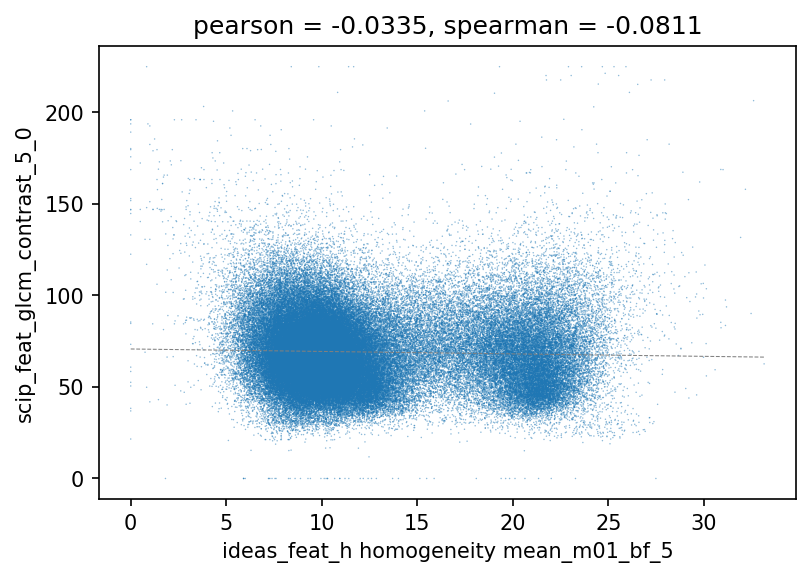

In [31]:
compare_features("ideas_feat_h homogeneity mean_m01_bf_5", "scip_feat_glcm_contrast_5_0")

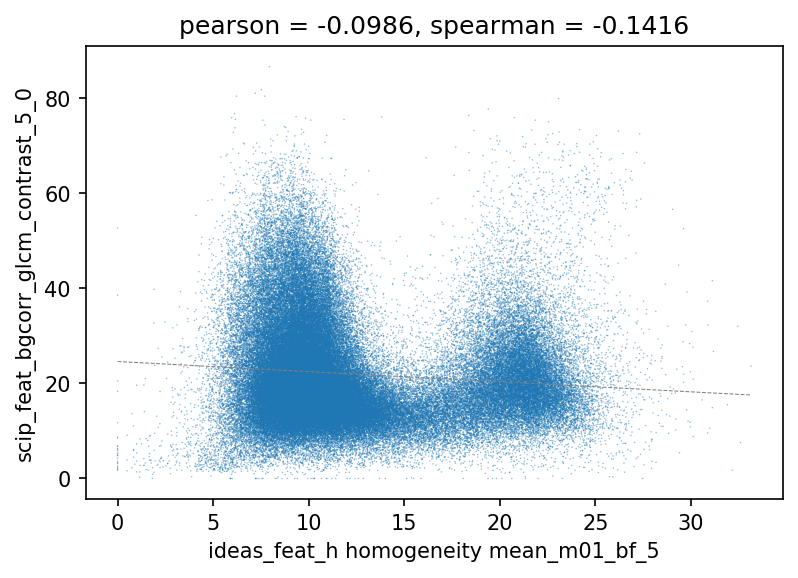

In [32]:
compare_features("ideas_feat_h homogeneity mean_m01_bf_5", "scip_feat_bgcorr_glcm_contrast_5_0")

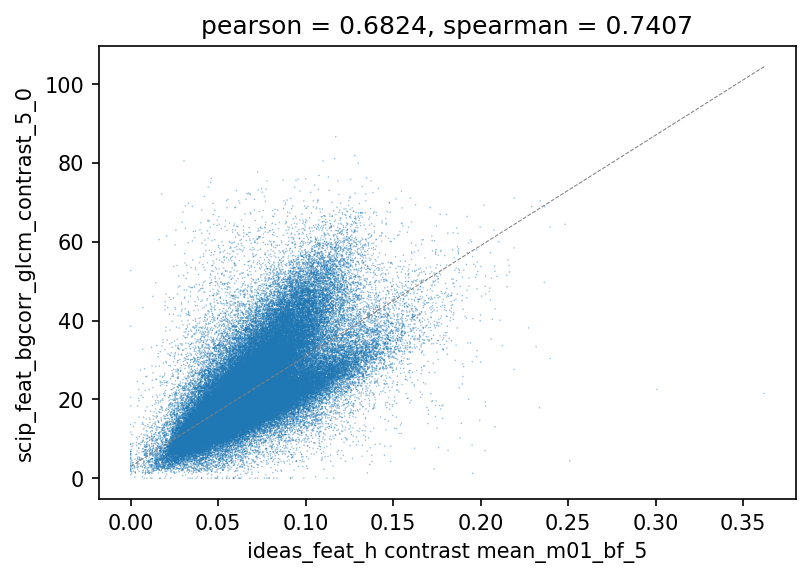

In [33]:
compare_features("ideas_feat_h contrast mean_m01_bf_5", "scip_feat_bgcorr_glcm_contrast_5_0")

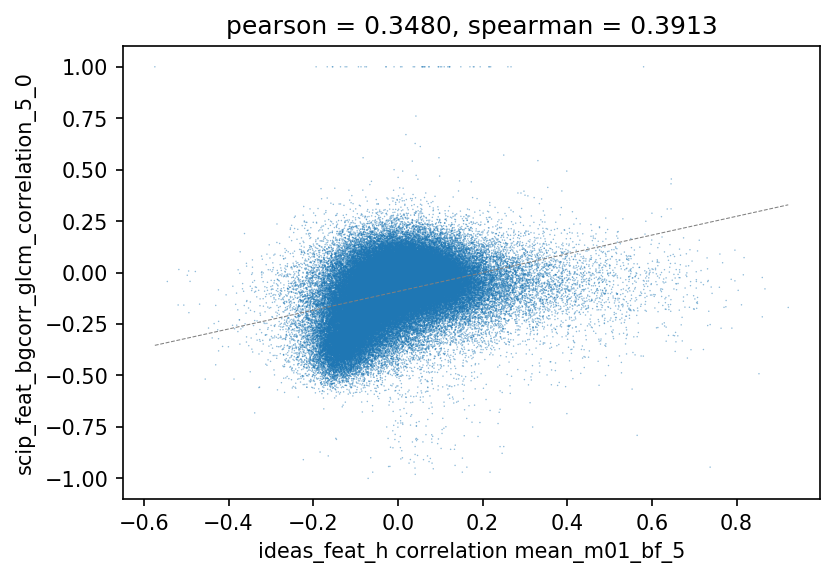

In [34]:
compare_features("ideas_feat_h correlation mean_m01_bf_5", "scip_feat_bgcorr_glcm_correlation_5_0")

### Shape

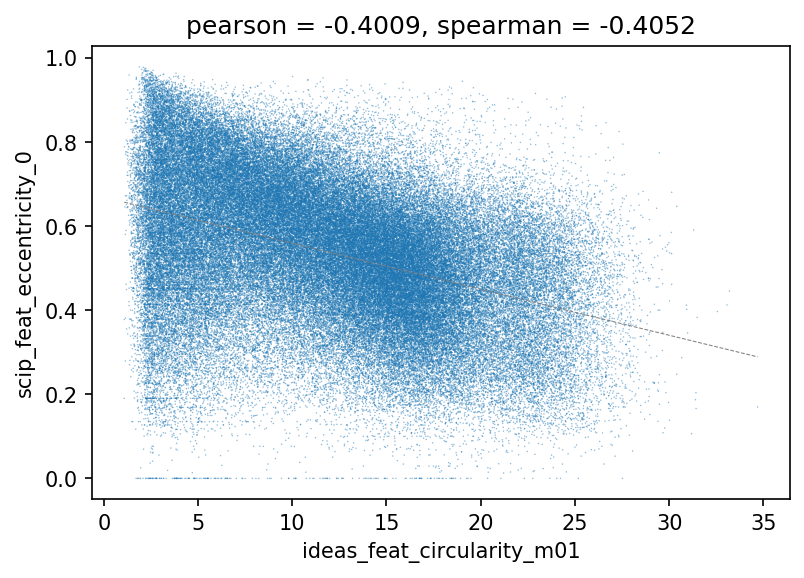

In [35]:
compare_features("ideas_feat_circularity_m01", "scip_feat_eccentricity_0")

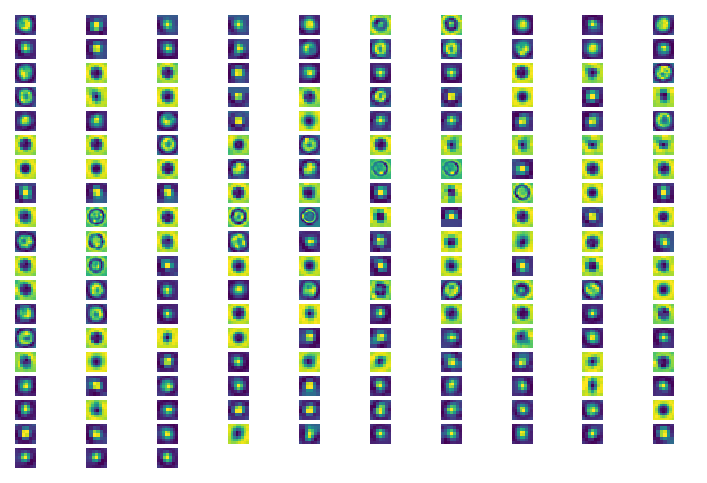

In [82]:
sel1 = df_joined["scip_feat_eccentricity_0"] == 0
sel2 = df_joined["ideas_feat_circularity_m01"] > 0
core.plot_gate_zarr(sel1 & sel2, df_joined)

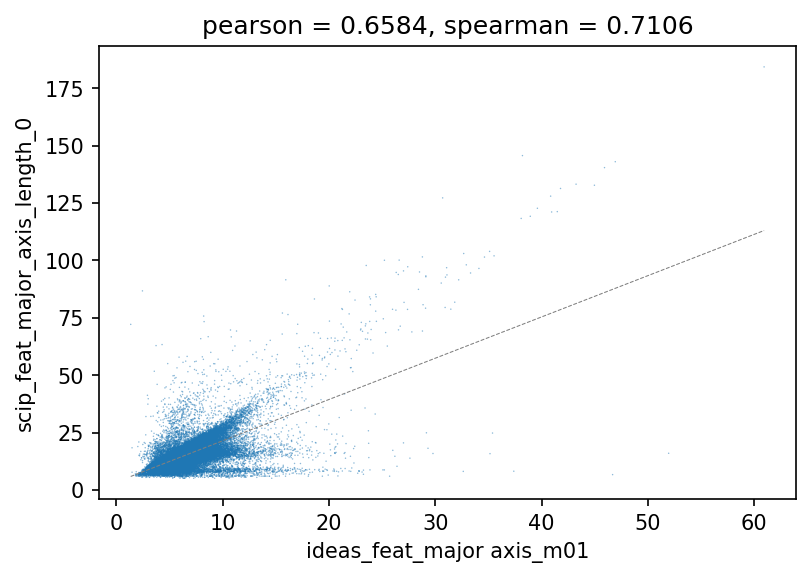

In [36]:
compare_features("ideas_feat_major axis_m01", "scip_feat_major_axis_length_0")

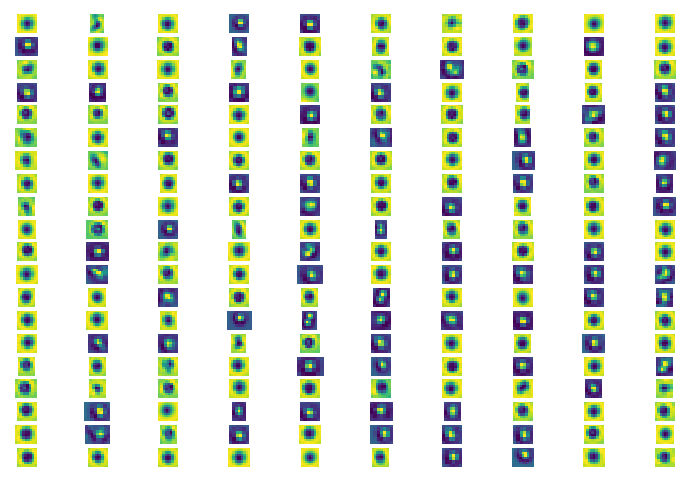

In [83]:
sel1 = df_joined["scip_feat_major_axis_length_0"] < 10
sel2 = df_joined["ideas_feat_major axis_m01"] > 10
core.plot_gate_zarr(sel1 & sel2, df_joined)

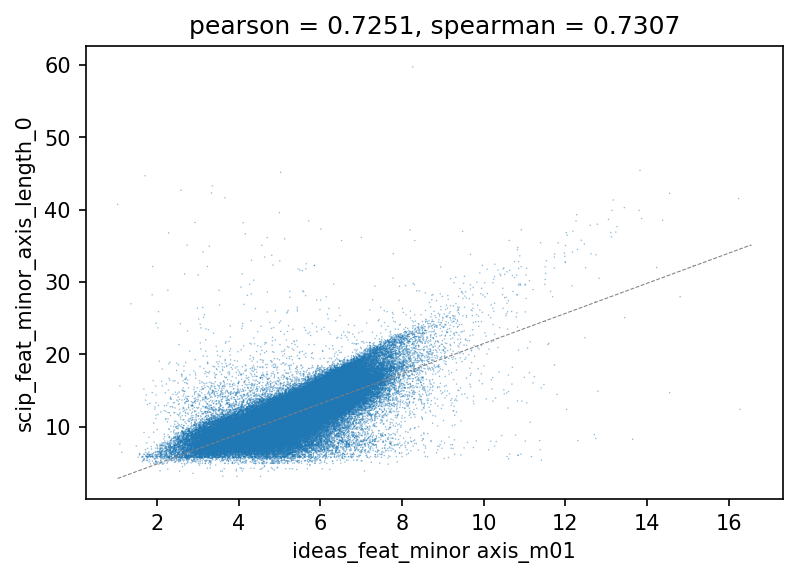

In [37]:
compare_features("ideas_feat_minor axis_m01", "scip_feat_minor_axis_length_0")

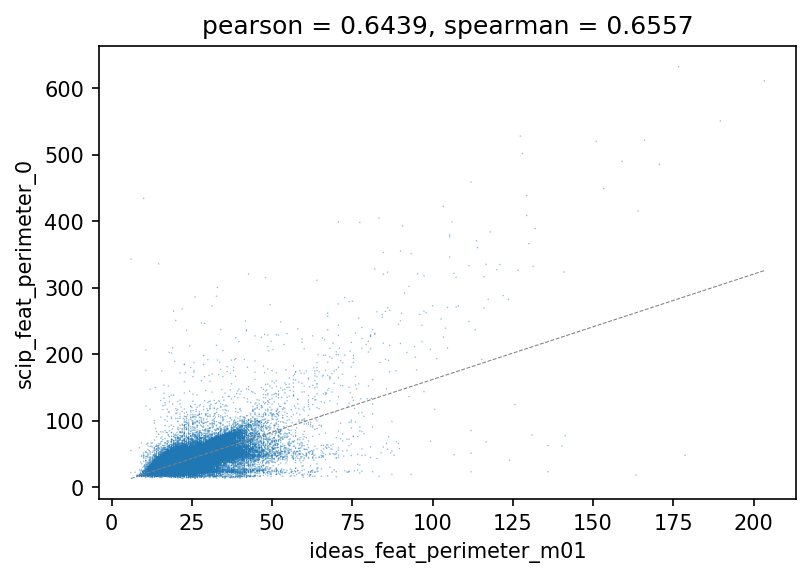

In [38]:
compare_features("ideas_feat_perimeter_m01", "scip_feat_perimeter_0")

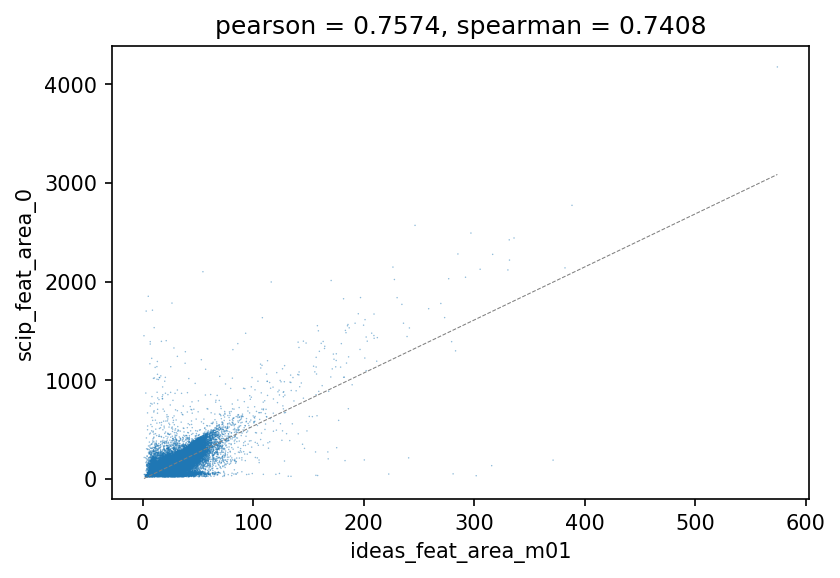

In [39]:
compare_features("ideas_feat_area_m01", "scip_feat_area_0")

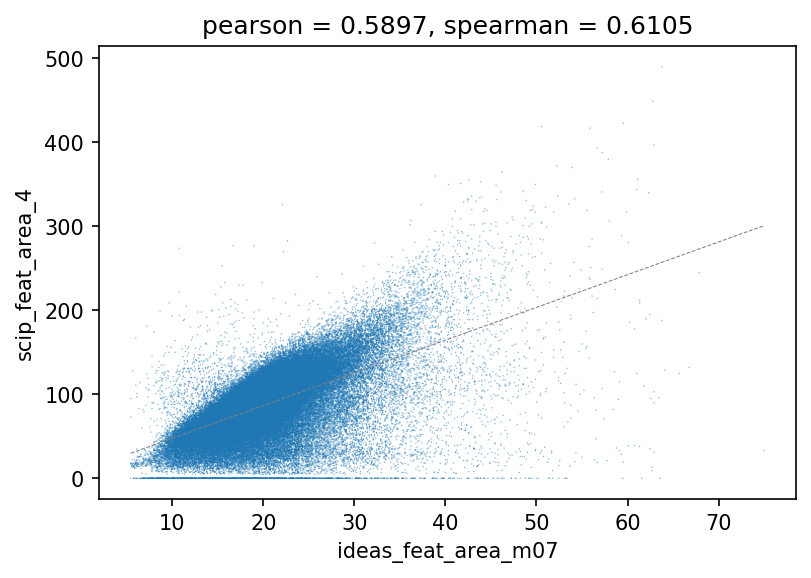

In [40]:
compare_features("ideas_feat_area_m07", "scip_feat_area_4")

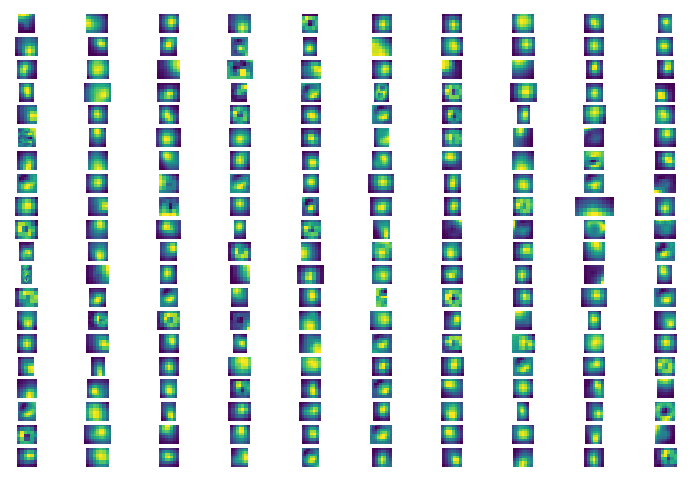

In [41]:
sel1 = df_joined["scip_feat_area_4"] == 0
sel2 = df_joined["ideas_feat_area_m07"] > 0
core.plot_gate_zarr(sel1 & sel2, df_joined, channel=4)

In [97]:
df_joined[sel1 & sel2].iloc[2][["meta_path", "meta_zarr_idx"]].values

array(['/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Ctrl_T0_R1_26.zarr',
       273], dtype=object)

### Intensity features

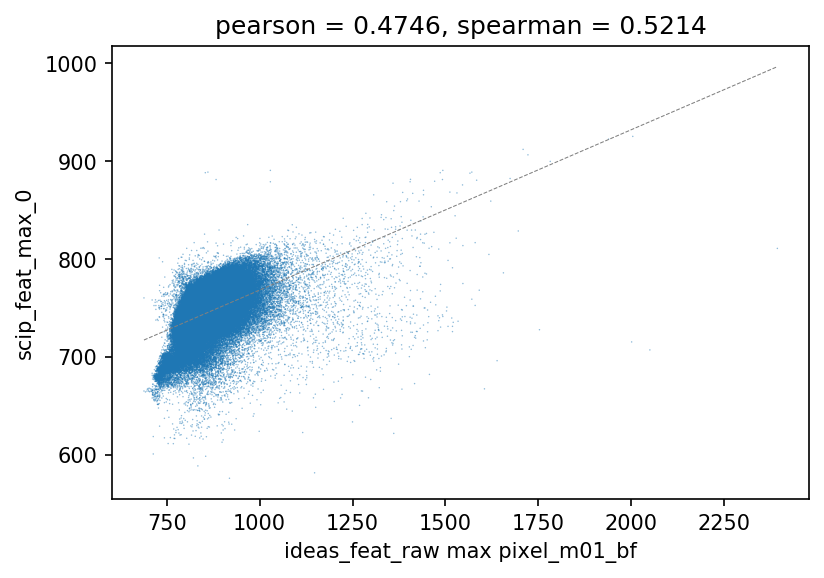

In [42]:
compare_features("ideas_feat_raw max pixel_m01_bf", "scip_feat_max_0")

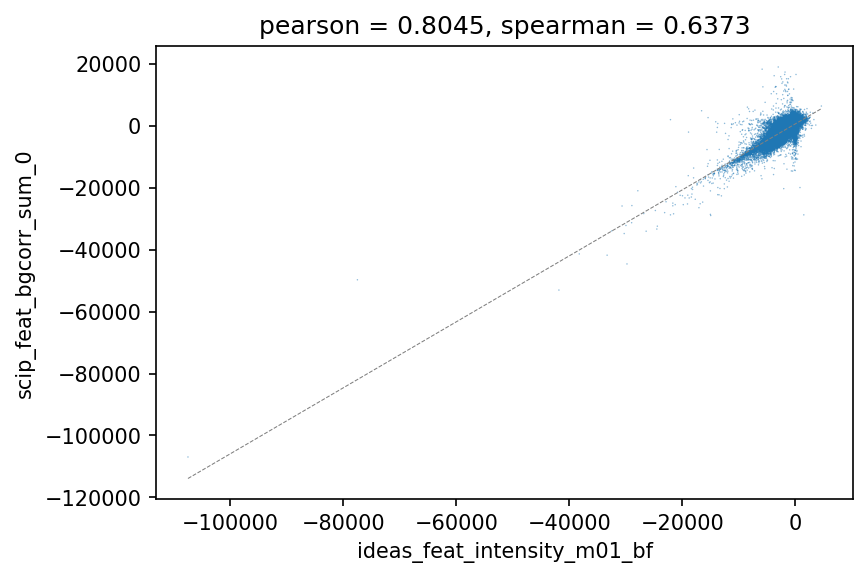

In [43]:
compare_features("ideas_feat_intensity_m01_bf", "scip_feat_bgcorr_sum_0")

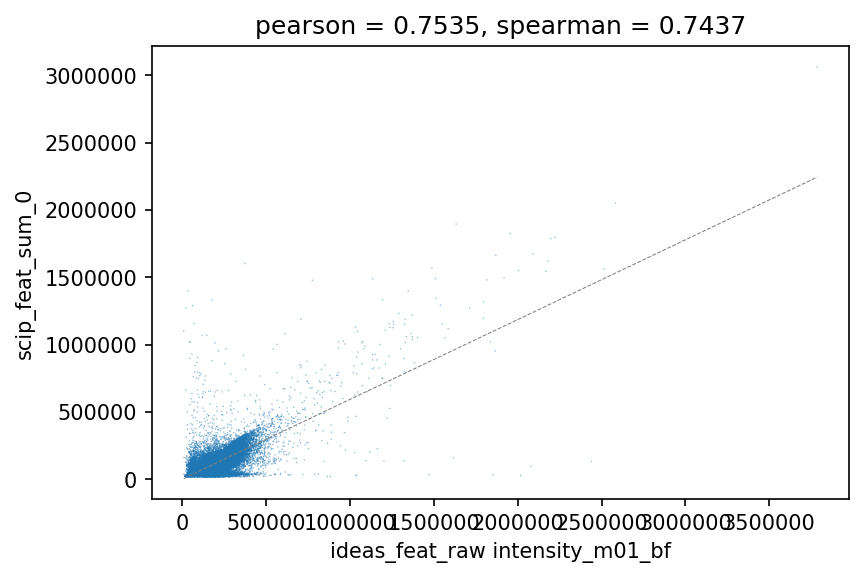

In [44]:
compare_features("ideas_feat_raw intensity_m01_bf", "scip_feat_sum_0")

/tmp/093f5d9a29/ipykernel_15612/2403142069.py:1: RankWarning: Polyfit may be poorly conditioned
  compare_features("ideas_feat_raw mean pixel_m01_bf", "scip_feat_mean_0")


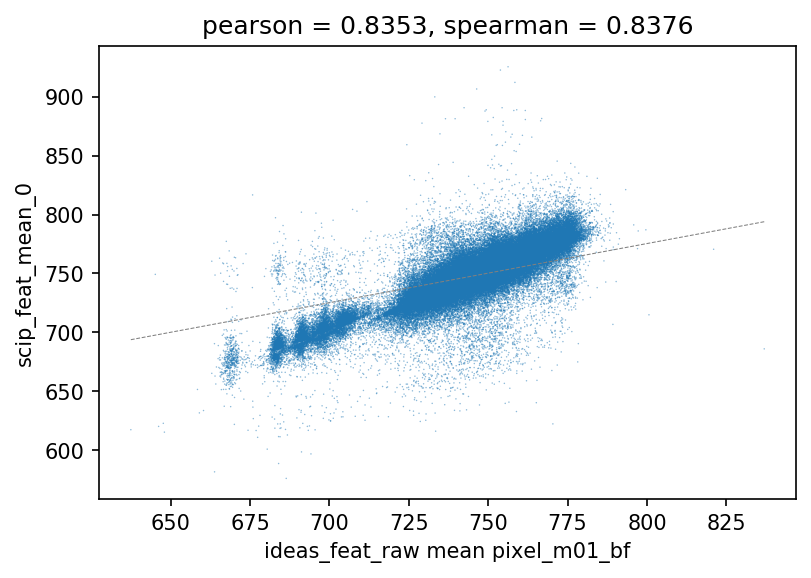

In [45]:
compare_features("ideas_feat_raw mean pixel_m01_bf", "scip_feat_mean_0")

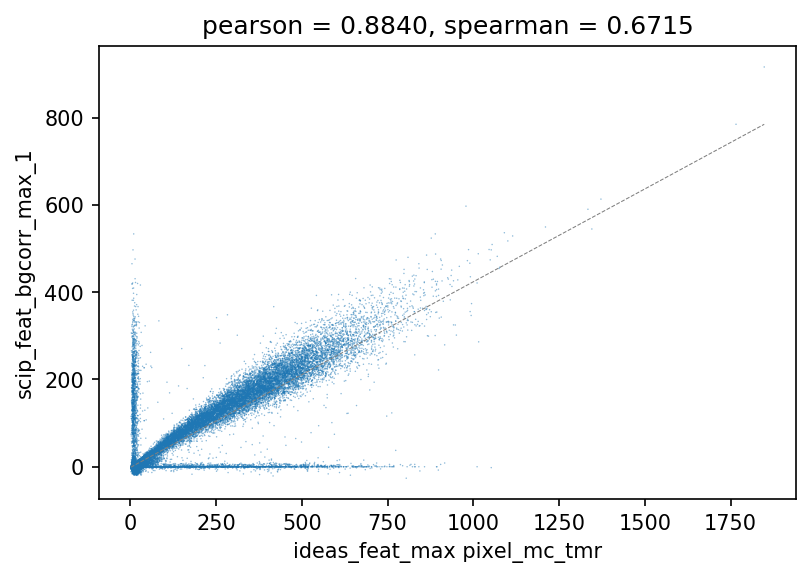

In [46]:
compare_features("ideas_feat_max pixel_mc_tmr", "scip_feat_bgcorr_max_1")

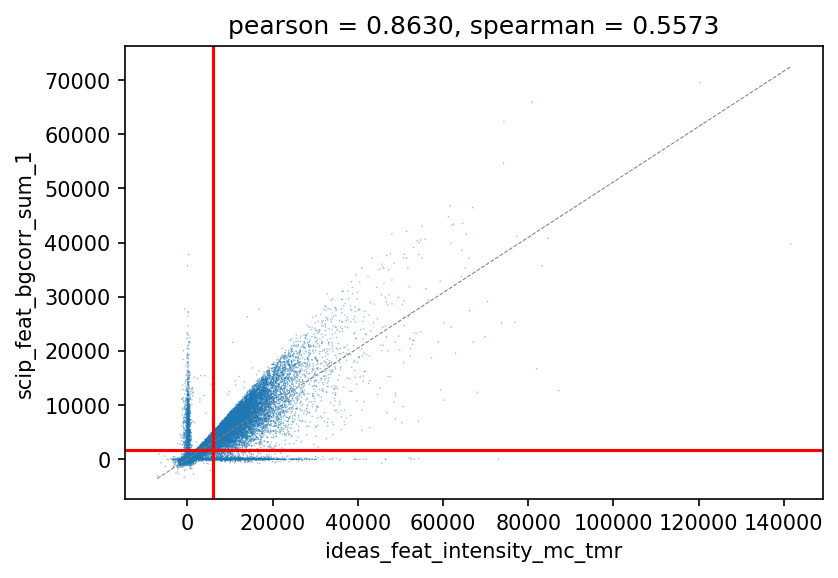

In [47]:
ax = compare_features("ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")
ax.axvline(6000, color="red")
ax.axhline(1700, color="red")

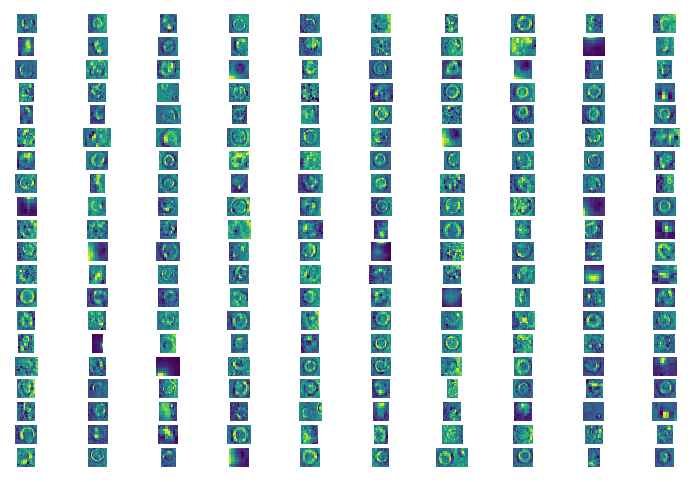

In [56]:
sel1 = df_joined["scip_feat_bgcorr_sum_1"] > 0
sel2 = df_joined["scip_feat_bgcorr_sum_1"] < 1700
sel3 = df_joined["ideas_feat_intensity_mc_tmr"] > 6000
core.plot_gate_zarr(sel1 & sel2 & sel3, df_joined, channel=1)

In [61]:
df_joined[sel1 & sel2 & sel3].iloc[0]

meta_bbox_minr                                     10.0
meta_bbox_minc                                      8.0
meta_bbox_maxr                                     22.0
meta_bbox_maxc                                     18.0
meta_regions_0                                      1.0
                                                ...    
ideas_feat_mean pixel_m06_ch06                24.125616
ideas_feat_median pixel_m06_ch06              15.850806
ideas_feat_aspect ratio_m06                    0.521675
ideas_feat_angle intensity_m06_ch06            0.032075
ideas_feat_aspect ratio intensity_m06_ch06     0.418221
Name: (14877, 1, 2), Length: 557, dtype: object

In [59]:
df_joined[sel1 & sel2 & sel3].iloc[0][["scip_feat_bgcorr_sum_1", "ideas_feat_intensity_mc_tmr"]].values

array([41.000274658203125, 6714.161], dtype=object)

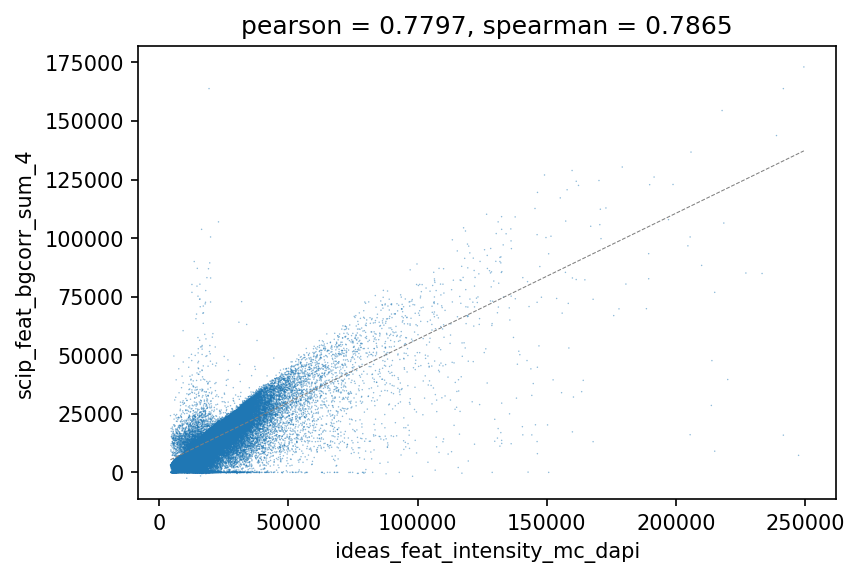

In [48]:
compare_features("ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_4")